# Introduction to PyMC3

## Objectives and instructions for PW#1 preparation
1. Please don't spend too much time researching individual terms you don't know.
2. The purpose is to get a **high-level overview** overview of the workflow associated with working on Bayesian models.
3. Lots of considerations go into designing e.g. priors but that's not the objective for this week.
4. There is one single exercise which asks you to mess up settings for the MCMC inference. This should be a playful exercise - no need to analyze anything.
5. Most important **this is a calibration week** - we will ask you questions about how much effort this took, whether you enjoyed it, whether you feel you have understood (at a high level) the workflow, etc.  Let's make sure we set up future sessions for success.
6. **I hope you will have fun doing this - remember we are doing this for us.**

### Reading group
At the next reading group:
- We will quickly go through the part for home study and resolve any questions.
- We will solve a very simple Bayesian inference problem analytically (related to the Bayesian Clinical Trial paper previously in the reading group).  We will define the term conjugate distributions.
- We will discuss the need for a general "inference machine" - sampling, variational inference.

### Instructions
Do not worry if you don't understand everything (this is likely and expected) - the idea is to get acquainted with the workflow and understand the syntax at an introductory/high level.

### Constructing a Bayesian model

Let's briefly cover some ideas regarding Bayesian analysis using Markov chain Monte Carlo (MCMC) methods. You might wonder why a numerical simulation method like MCMC is the standard approach for fitting Bayesian models. 

Gelman et al. (2013) break down the business of Bayesian analysis into three primary steps:

1. Specify a full probability model, including all parameters, data, transformations, missing values and predictions that are of interest.
2. Calculate the posterior distribution of the unknown quantities in the model, conditional on the data.
3. Perform model checking to evaluate the quality and suitablility of the model.

While each of these steps is challenging, it is the second step that is the most difficult for non-trivial models, and was a bottleneck for the adoption of Bayesian methods for decades. 

### Bayesian Inference

At this point, we should all be familiar with **Bayes Formula**:

![bayes formula](images/bayes_formula.png)

The equation expresses how our belief about the value of \\(\theta\\), as expressed by the **prior distribution** \\(P(\theta)\\) is reallocated following the observation of the data \\(y\\), as expressed by the posterior distribution the posterior distribution.

Computing the posterior distribution is called the **inference problem**, and is usually the goal of Bayesian analysis.

The innocuous denominator \\(Pr(y)\\) (the model **evidence**, or **marginal likelihood**) cannot be calculated directly, and is actually the expression in the numerator, integrated over all \\(\theta\\):

<div style="font-size: 150%;">  
\\[Pr(\theta|y) = \frac{Pr(y|\theta)Pr(\theta)}{\int Pr(y|\theta)Pr(\theta) d\theta}\\]
</div>

Computing this integral, which may involve many variables, is generally intractible with analytic methods. This is the major compuational hurdle for Bayesian analysis.


## A Motivating Example: Linear Regression

We first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, the unknown variables in the model must be assigned a prior distribution. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

### Generating data

We simulate the (artificial) data from this model using only NumPy's `random` module.  This is an arbitrary choice, we could just have fixed arrays for $X_1$ and $X_2$.

In [1]:
import numpy as np

# Initialize random number generator
np.random.seed(123)

# We will generate a dataset of 100 samples.
size = 100

# We generate our "predictor" variables
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Now we will fix values of the model parameters $\alpha, \beta_1, \beta_2$ and $\sigma$ and use those fixed values to create the observations $Y$ to build a complete dataset of triples $X_1, X_2, Y$.

In [2]:
# True parameter values - this is our model and what we are trying to estimate
alpha, sigma = 1, 1
beta = [1, 2.5]

# Here is where we compute Y from the simulated X1 and X2 using the true model parameters
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Here is what the simulated data look like. We use the `pylab` module from the plotting library matplotlib. 

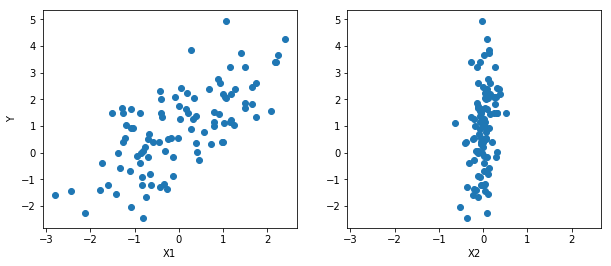

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

### Model Specification

Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above. 

First, we import PyMC. We use the convention of importing it as `pm`.

In [4]:
import pymc3 as pm

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now we build our model, which we will present in full first, then explain each part line-by-line.

In [5]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

The first line,

```python
basic_model = Model()
```

creates a new `Model` object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a  `with` statement:

```python
with basic_model:
```
This creates a *context manager*, with our `basic_model` as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the `with` statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable without a `with model:` statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

```python
alpha = Normal('alpha', mu=0, sd=10)
beta = Normal('beta', mu=0, sd=10, shape=2)
sigma = HalfNormal('sigma', sd=1)
```
create a **stochastic** random variables with a Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10 for the regression coefficients, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic). 

We call the `Normal` constructor to create a random variable to use as a normal prior. The first argument is always the *name* of the random variable, which should almost always match the name of the Python variable being assigned to, since it sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case `mu`, the mean, and `sd`, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution's parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Binomial` and many others, are available in PyMC3.

The `beta` variable has an additional `shape` argument to denote it as a vector-valued parameter of size 2. The `shape` argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (*e.g.* `shape=(5,7)` makes random variable that takes on 5 by 7 matrix values). 

Detailed notes about distributions, sampling methods and other PyMC3 functions are available via the `help` function.

In [6]:
help(pm.Normal) #try help(Model), help(Uniform) or help(basic_model)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  ========  ==========================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\mu`
 |  Variance  :math:`\dfrac{1}{\tau}` or :math:`\sigma^2`
 |  ========  ==========================================
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      x = np.linspace(-5.0, 5.0, 1000)
 |      fig, ax = plt.subplots()
 |      f = lambda mu, sd : st.

Having defined the priors, the next statement creates the expected value `mu` of the outcomes, specifying the linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic** random variable, which implies that its value is *completely* determined by its parents' values. That is, there is no uncertainty beyond that which is inherent in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the two products of the coefficients in `beta` and the predictor variables, whatever their values may be. 

PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` (for inner product) and `inv` (for inverse) are also provided. 

The final line of the model, defines `Y_obs`, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a `numpy.ndarray` or `pandas.DataFrame` object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.

### Model fitting

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the *maximum a posteriori* (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

#### Maximum a posteriori methods

The **maximum a posteriori (MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn't representative of the distribution. PyMC3 provides this functionality with the `find_MAP` function.

Below we find the MAP for our original model. The MAP is returned as a parameter **point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values. 

In [7]:
map_estimate = pm.find_MAP(model=basic_model)
    
map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1325.24it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma': array(0.96298858),
 'sigma_log__': array(-0.03771373)}

By default, `find_MAP` uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the `scipy.optimize` module. For example, below we use Powell's method to find the MAP.

In [8]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)
    
map_estimate

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -149.47:   4%|▎         | 176/5000 [00:00<00:02, 2080.70it/s]

Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma': array(0.96568062),
 'sigma_log__': array(-0.03492212)}

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together. 

Most techniques for finding the MAP estimate also only find a *local* optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

#### Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution.

**Note** that the sampler will by default sample 1500 samples and **throw away the first 500 samples**, as they are considered 'burn-in' samples. 

In [9]:
with basic_model:
    # draw posterior samples
    trace = pm.sample(draws=2000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:03<00:00, 717.78it/s]


The `sample` function runs the samping methods for the given number of iterations and returns a `Trace` object containing the samples collected, in the order they were collected. The `trace` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the `alpha` variable as follows:

In [10]:
trace['alpha'][-5:]

array([1.03437053, 0.97973268, 0.84974853, 0.92306123, 0.74858078])

### Posterior analysis
`PyMC3` provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using `traceplot`.

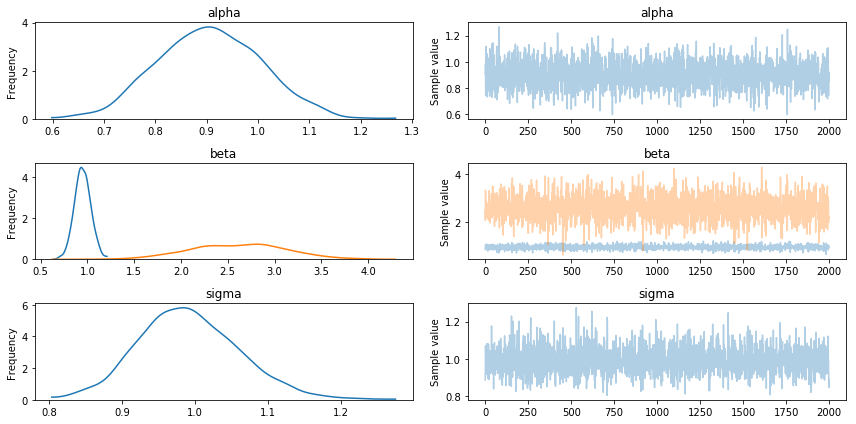

In [11]:
_ = pm.traceplot(trace)

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the `summary` function provides a text-based output of common posterior statistics:

## PW Exercise
Can you reduce the sampling so the results are totally different? Note, the trace contains all the samples, so just go ahead and use indexing to reduce the number of samples used for posterior plot (and use samples from start) instead of going back and changing the sampling initially.

- Can you make the graph on the right clearly irregular?
- When you compare posterior estimates for the betas in your traceplot below and in the (stabilized) traceplot above, can you produce a large difference?
- Where are the differences you see?

In [12]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.906            0.100            0.002            [0.719, 1.103]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.719          0.836          0.905          0.976          1.106


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.947            0.087            0.002            [0.781, 1.119]
  2.602            0.513            0.011            [1.568, 3.543]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.777          0.889          0.945          1.005          1.118
  1.620          2.248          2.616   

# PW: Stop here for week 1

## Motivating Example: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period.

Let's build a model for this series and attempt to estimate when the change occurred. First we plot the data and specify the form of the model mathematically and proceed to encoded it in PyMC3 and run inference.

### Notes on the model
This model is more complicated than the previous GLM model and shows some of the flexibility of the Bayesian approach. The purpose of the model is to try and identify a discrete change in the rate of mining accidents. The model assumes that up to a certain year $\tau$ the rate was $\lambda_1$ while starting with $\tau$ the rate is $\lambda_2$.

The prior on $\tau$ is a discrete uniform distribution, since all years are equally likely to be the swiching point. The priors on the rates $\lambda_i$ are exponential distributions. In general any prior distribution with support on non-negative real numbers is permissible. Using an exponential distribution results in the prior having more mass near zero, signifying that the experimenter expects low rates.

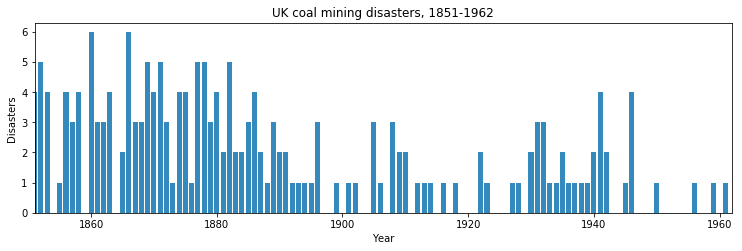

In [13]:
import numpy as np
import matplotlib.pyplot as plt

disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

n_years = len(disasters_data)

plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_data, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962);

We represent our conceptual model formally as a statistical model:

$$\begin{array}{ccc}  
(y_t | \tau, \lambda_1, \lambda_2) \sim\text{Poisson}\left(r_t\right), & r_t=\left\{
\begin{array}{lll}             
\lambda_1 &\text{if}& t< \tau\\ 
\lambda_2 &\text{if}& t\ge \tau             
\end{array}\right.,&t\in[t_l,t_h]\\         
\tau \sim \text{DiscreteUniform}(t_l, t_h)\\         
\lambda_1\sim \text{Exponential}(a)\\         
\lambda_2\sim \text{Exponential}(b)     
\end{array}$$

Because we have defined $y$ by its dependence on $\tau$, $\lambda_1$ and $\lambda_2$, the latter three are known as the *parents* of $y$, and $y$ is called their *child*. Similarly, the parents of $\tau$ are $t_l$ and $t_h$, and $\tau$ is the child of $t_l$ and $t_h$. The parameters $a$ and $b$ are the rate parameters of the prior exponential distribution and are set by the experimenter (in the model below $a=b=1$).

## Implementing a PyMC Model

At the model-specification stage (before the data are observed), $y$, $\tau$, $\lambda_1$, and $\lambda_2$ are all random variables. Bayesian "random" variables have not necessarily arisen from a physical random process. The Bayesian interpretation of probability is **epistemic**, meaning random variable $x$'s probability distribution $p(x)$ represents our knowledge and uncertainty about $x$'s value. Candidate values of $x$ for which $p(x)$ is high are relatively more probable, given what we know. 

We can generally divide the variables in a Bayesian model into two types: **stochastic** and **deterministic**. The only deterministic variable in this model is $r$. If we knew the values of $r$'s parents, we could compute the value of $r$ exactly. A deterministic like $r$ is defined by a mathematical function that returns its value given values for its parents. Deterministic variables are sometimes called the *systemic* part of the model. The nomenclature is a bit confusing, because these objects usually represent random variables; since the parents of $r$ are random, $r$ is random also.

On the other hand, even if the values of the parents of variables `switchpoint`, `disasters` (before observing the data), `early_mean` or `late_mean` were known, we would still be uncertain of their values. These variables are stochastic, characterized by probability distributions that express how plausible their candidate values are, given values for their parents.

Let's begin by defining the unknown switchpoint as a discrete uniform random variable:

In [14]:
from pymc3 import DiscreteUniform, Model

with Model() as disaster_model:

    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=n_years)

We have done two things here. First, we have created a `Model` object; a `Model` is a Python object that encapsulates all of the variables that comprise our theoretical model, keeping them in a single container so that they may be used as a unit. After a `Model` is created, we can populate it with all of the model components that we specified when we wrote the model down. 

Notice that the `Model` above was declared using a `with` statement. This expression is used to define a Python idiom known as a **context manager**. Context managers, in general, are used to manage resources of some kind within a program. In this case, our resource is a `Model`, and we would like to add variables to it so that we can fit our statistical model. The key characteristic of the context manager is that the resources it manages are only defined within the indented block corresponding to the `with` statement. PyMC uses this idiom to automatically add defined variables to a model. Thus, any variable we define is automatically added to the `Model`, without having to explicitly add it. This avoids the repetitive syntax of `add` methods/functions that you see in some machine learning packages:

```python
model.add(a_variable)
model.add(another_variable)
model.add(yet_another_variable)
model.add(and_again)
model.add(please_kill_me_now)
...
```

In fact, PyMC variables cannot be defined without a corresponding `Model`:

In [15]:
# remove comment to show error
#oops = DiscreteUniform('oops', lower=0, upper=10)

However, variables can be explicitly added to models without the use of a context manager, via the variable's optional `model` argument.

```python
disaster_model = Model()
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, model=disaster_model)
```

### Probability mass/density functions implemented in PyMC3

PyMC3 includes most of the common random variable **distributions** used for statistical modeling.

In [16]:
from pymc3 import distributions
distributions.__all__

['Uniform',
 'Flat',
 'HalfFlat',
 'Normal',
 'Beta',
 'Exponential',
 'Laplace',
 'StudentT',
 'Cauchy',
 'HalfCauchy',
 'Gamma',
 'Weibull',
 'Bound',
 'Lognormal',
 'HalfStudentT',
 'StudentTpos',
 'ChiSquared',
 'HalfNormal',
 'Wald',
 'Pareto',
 'InverseGamma',
 'ExGaussian',
 'VonMises',
 'Binomial',
 'BetaBinomial',
 'Bernoulli',
 'Poisson',
 'NegativeBinomial',
 'ConstantDist',
 'Constant',
 'ZeroInflatedPoisson',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedBinomial',
 'DiscreteUniform',
 'Geometric',
 'Categorical',
 'DensityDist',
 'Distribution',
 'Continuous',
 'Discrete',
 'NoDistribution',
 'TensorType',
 'MvNormal',
 'MvStudentT',
 'Dirichlet',
 'Multinomial',
 'Wishart',
 'WishartBartlett',
 'LKJCholeskyCov',
 'LKJCorr',
 'AR1',
 'AR',
 'GaussianRandomWalk',
 'MvGaussianRandomWalk',
 'MvStudentTRandomWalk',
 'GARCH11',
 'SkewNormal',
 'Mixture',
 'NormalMixture',
 'Triangular',
 'DiscreteWeibull',
 'Gumbel',
 'Logistic',
 'Interpolated',
 'Bound']

By having a library of variables that represent statistical distributions, users are relieved of having to code distrbutions themselves. 

Similarly, we can create the exponentially-distributed variables `early_mean` and `late_mean` for the early and late Poisson rates, respectively (also in the context of the model `distater_model`):

In [17]:
from pymc3 import Exponential

with disaster_model:
    
    early_mean = Exponential('early_mean', 1)
    late_mean = Exponential('late_mean', 1)

Next, we define the variable `rate`, which selects the early rate `early_mean` for times before `switchpoint` and the late rate `late_mean` for times after `switchpoint`. We create `rate` using the `switch` function, which returns `early_mean` when the switchpoint is larger than (or equal to) a particular year, and `late_mean` otherwise.

In [18]:
from pymc3.math import switch

with disaster_model:
    
    rate = switch(switchpoint >= np.arange(n_years), early_mean, late_mean)

The last step is to define the **data likelihood**, or sampling distribution. In this case, our measured outcome is the number of disasters in each year, `disasters`. This is a stochastic variable but unlike `early_mean` and `late_mean` we have *observed* its value. To express this, we set the argument `observed` to the observed sequence of disasters. This tells PyMC that this distribution's value is fixed, and should not be changed:

In [19]:
from pymc3 import Poisson

with disaster_model:
    
    disasters = Poisson('disasters', mu=rate, observed=disasters_data)

> ### Why are data and unknown variables represented by the same object?

>Since its represented by PyMC random variable object, `disasters` is defined by its dependence on its parent `rate` even though its value is **fixed**. This isn't just a quirk of PyMC's syntax; Bayesian hierarchical notation itself makes no distinction between random variables and data. The reason is simple: to use Bayes' theorem to compute the posterior, we require the likelihood. Even though `disasters`'s value is known and fixed, we need to formally assign it a *probability distribution* as if it were a random variable. Remember, the likelihood and the probability function are essentially the same, except that the former is regarded as a function of the parameters and the latter as a function of the data. This point can be counterintuitive at first, as many peoples' instinct is to regard data as fixed a priori and unknown variables as dependent on the data. 

> One way to understand this is to think of statistical models as predictive models for data, or as models of the processes that gave rise to data. Before observing the value of `disasters`, we could have sampled from its prior predictive distribution $p(y)$ (*i.e.* the marginal distribution of the data) as follows:

> -   Sample `early_mean`, `switchpoint` and `late_mean` from their
>     priors.
> -   Sample `disasters` conditional on these values.

> Even after we observe the value of `disasters`, we need to use this process model to make inferences about `early_mean` , `switchpoint` and `late_mean` because its the only information we have about how the variables are related.

> We will see later that we can sample from this fixed stochastic random variable, to obtain predictions after having observed our data.

The model that we specified at the top of the page has now been fully implemented in PyMC3. Let's have a look at the model's attributes to see what we have.

The stochastic nodes in the model are identified in the `vars` (*i.e.* variables) attribute:

In [20]:
disaster_model.vars

[switchpoint, early_mean_log__, late_mean_log__]

The last two variables are the log-transformed versions of the early and late rate parameters. In PyMC3, variables with purely positive priors like `Exponential` are **transformed** with a log function. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named `<variable name>_log_`) is added to the model for sampling. In this model this happens behind the scenes. Variables with priors that constrain them on two sides, like `Beta` or `Uniform` (continuous), are also transformed to be unconstrained but with a log odds transform.

The original variables have become deterministic nodes in the model, since they only represent values that have been back-transformed from the transformed variable, which has been subject to fitting or sampling.

In [21]:
disaster_model.deterministics

[early_mean, late_mean]

You might wonder why `rate`, which is a deterministic component of the model, is not in this list. This is because, unlike the other components of the model, `rate` has not been given a name and given a formal PyMC data structure. It is essentially an **intermediate calculation** in the model, implying that we are not interested in its value when it comes to summarizing the output from the model. Most PyMC objects have a name assigned; these names are used for storage and post-processing:

-   as keys in on-disk databases,
-   as axis labels in plots of traces,
-   as table labels in summary statistics.

If we wish to include `rate` in our output, we need to make it a `Deterministic` object, and give it a name:

In [22]:
from pymc3 import Deterministic

with disaster_model:
    
    rate = Deterministic('rate', switch(switchpoint >= np.arange(n_years), early_mean, late_mean))

Now, `rate` is included in the `Model`'s deterministics list, and the model will retain its samples during MCMC sampling, for example.

In [23]:
disaster_model.deterministics

[early_mean, late_mean, rate]

## PyMC3 Variables

Each of the built-in statistical variables are subclasses of the generic `Distribution` class in PyMC3. The `Distribution` carries relevant **attributes** about the probability distribution, such as the data type (called `dtype`), any relevant transformations (`transform`, see below), and initial values (`init_value`).

In [24]:
disasters.dtype

'int64'

In [25]:
early_mean.init_value

array(0.69314718)

PyMC's built-in distribution variables can also be used to generate **random values** from that variable. For example, the `switchpoint`, which is a discrete uniform random variable, can generate random draws:

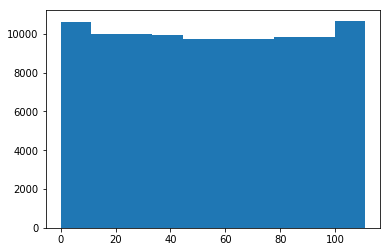

In [26]:
plt.hist(switchpoint.random(size=100000));

As we noted earlier, some variables have undergone **transformations** prior to sampling. Such variables will have `transformed` attributes that points to the variable that it has been transformed to.

In [27]:
early_mean.transformed

early_mean_log__

Variables will usually have an associated distribution, as determined by the constructor used to create it. For example, the `switchpoint` variable was created by calling `DiscreteUniform()`. Hence, its distribution is `DiscreteUniform`:

In [28]:
switchpoint.distribution

As with all Python objects, the underlying type of a variable can be exposed with the `type()` function:

In [29]:
type(switchpoint)

pymc3.model.FreeRV

In [30]:
type(disasters)

pymc3.model.ObservedRV

We will learn more about these types in an upcoming section.

## Variable log-probabilities

All PyMC3 stochastic variables can evaluate their probability mass or density functions at a particular value, given the values of their parents. The **logarithm** of a stochastic object's probability mass or density can be
accessed via the `logp` method.

Note: the PyMC3 stochastic variables don't implement mass/density at all, only the logarithm.  An exponent must be applied to get the original density/mass.

In [31]:
switchpoint.logp({'switchpoint':15, 'early_mean_log__':1, 'late_mean_log__':1})

array(-4.71849887)

For **vector-valued** variables like `disasters`, the `logp` attribute returns the **sum** of the logarithms of
the joint probability or density of all elements of the value.

In [32]:
disasters.logp({'switchpoint':55, 'early_mean_log__':1, 'late_mean_log__':1})

array(-225.5380749)

## Fitting the model with MCMC

PyMC3's `sample` function will fit probability models (linked collections of variables) like ours using Markov chain Monte Carlo (MCMC) sampling. Unless we manually assign particular algorithms to variables in our model, PyMC will assign algorithms that it deems appropriate (it usually does a decent job of this):

In [33]:
from pymc3 import sample
with disaster_model:
    trace = sample(2000, init=None)

Assigned Metropolis to switchpoint
Assigned NUTS to early_mean_log__
Assigned NUTS to late_mean_log__
/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:02<00:00, 1190.09it/s]


This returns the Markov chain of draws from the model in a data structure called a **trace**.

In [34]:
trace

<MultiTrace: 1 chains, 2000 iterations, 6 variables>

The `sample()` function always takes at least one argument, `draws`, which specifies how many samples to draw. However, there are a number of additional optional arguments that are worth knowing about:

In [35]:
help(sample)

Help on function sample in module pymc3.sampling:

sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain=0, njobs=1, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=None, random_seed=-1, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 500. The number of tuned
        samples are discarded by default. See discard_tuned_samples.
    step : function or iterable of functions
        A step function or collection of functions. If there are variables
        without a step methods, step methods for those variables will
        be assigned automatically.
    init : str
        Initialization method to use for auto-assigned NUTS samplers.
    
        * auto : Choose a defau

The `step` argument is what allows users to manually override the sampling algorithms used to fit the model. For example, if we wanted to use a **slice sampler** to sample the `early_mean` and `late_mean` variables, we could specify it:

In [36]:
from pymc3 import Slice

with disaster_model:
    step_trace = sample(draws=1000, tune=500, step=Slice(vars=[early_mean, late_mean]))

Assigned Metropolis to switchpoint
100%|██████████| 1500/1500 [00:01<00:00, 952.00it/s]


### Accessing the samples

The output of the `sample` function is a `MultiTrace` object, which stores the sequence of samples for each variable in the model. These traces can be accessed using dict-style indexing:


In [37]:
trace['late_mean']

array([0.8836939 , 0.74801953, 0.76681783, ..., 0.92164241, 0.95327818,
       1.07752297])

The trace can also be sliced using the NumPy array slice `[start:stop:step]`. 

In [38]:
trace['late_mean', -5:]

array([0.843669  , 0.84096589, 0.92164241, 0.95327818, 1.07752297])

In [39]:
trace['late_mean', ::10]

array([0.8836939 , 1.10794423, 0.88961426, 1.02859836, 0.88683104,
       1.02219154, 0.93809579, 0.90858595, 1.14287629, 0.79588303,
       0.7219186 , 0.81248448, 0.88498937, 1.16921607, 0.8707468 ,
       0.95044748, 0.91399212, 0.83264775, 1.21788082, 0.97145779,
       0.93894313, 0.8910471 , 0.91488937, 0.70953195, 0.97263936,
       0.93740379, 1.09397202, 1.03266703, 0.91581113, 0.86703192,
       0.88577133, 1.08554874, 0.8449962 , 1.16539783, 0.76635579,
       0.95501577, 0.93393498, 0.8589555 , 0.76070738, 0.88435532,
       0.77366357, 0.77887888, 1.00391607, 0.70184826, 0.87697262,
       0.78413172, 1.01539159, 0.99732705, 0.97484658, 0.9057708 ,
       0.9276604 , 0.83493766, 0.9965277 , 1.01071361, 0.82057025,
       0.72641188, 1.17957627, 0.67543754, 0.93478072, 0.92772171,
       0.87026233, 0.90363201, 1.14723266, 0.90918113, 0.86467126,
       0.83270303, 0.80009898, 0.98493462, 0.89788268, 1.04968922,
       0.99160803, 0.92827172, 0.78285462, 0.78841871, 1.08199

### Sampling output

You can examine the marginal posterior of any variable by plotting a
histogram of its trace:

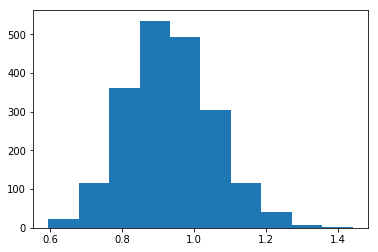

In [40]:
plt.hist(trace['late_mean']);

PyMC has its own plotting functionality dedicated to plotting MCMC output. For example, we can obtain a time series plot of the trace and a histogram using `traceplot`:

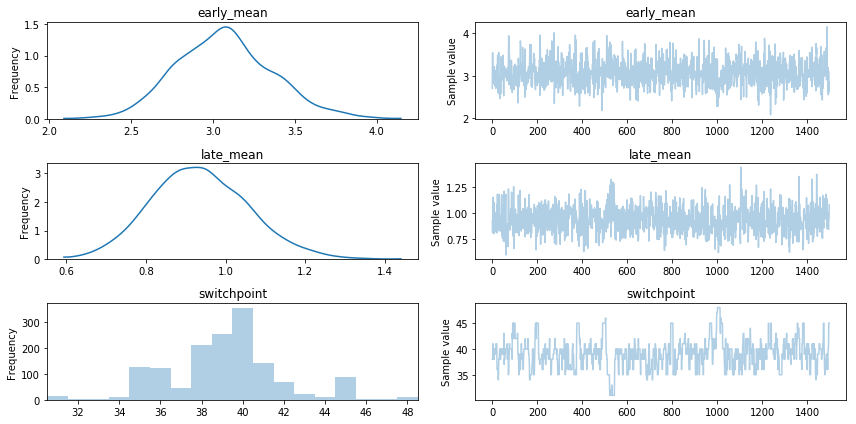

In [41]:
from pymc3 import traceplot

traceplot(trace[500:], varnames=['early_mean', 'late_mean', 'switchpoint']);

The upper left-hand pane of each figure shows the temporal series of the
samples from each parameter, while below is an autocorrelation plot of
the samples. The right-hand pane shows a histogram of the trace. The
trace is useful for evaluating and diagnosing the algorithm's
performance, while the histogram is useful for
visualizing the posterior.

For a non-graphical summary of the posterior, simply call the `stats` method.

In [42]:
from pymc3 import summary

summary(trace[500:], varnames=['early_mean', 'late_mean'])


early_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.072            0.293            0.010            [2.541, 3.688]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.541          2.870          3.071          3.258          3.688


late_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.934            0.122            0.004            [0.697, 1.176]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.709          0.850          0.930          1.016          1.190



## PW Exercise
Here we have more detail about the sample function and we have observed its output in detail. Important parameters for us now are **draws** and **tune**, which affect how many samples are drawn and how long the chain runs to stabilize before beginning sampling.

- Note that the model contains a switchpoint variable and is not end-to-end differntiable.
- Play around with the paraemters (hint: reduce both draws, tune) and re-run the cells above.
- Observe warnings emitted by the internal diagnostics of PyMC3.
- Observe how the output changes when you sample more/less.
- Get a feel for the variability in this model.
- No need to dig deeper into this or try to study details - we will do that later.

# Revisiting probability distributions
Let us revisit the list of distributions above and examine them in more detail.


In [43]:
distributions.__all__

['Uniform',
 'Flat',
 'HalfFlat',
 'Normal',
 'Beta',
 'Exponential',
 'Laplace',
 'StudentT',
 'Cauchy',
 'HalfCauchy',
 'Gamma',
 'Weibull',
 'Bound',
 'Lognormal',
 'HalfStudentT',
 'StudentTpos',
 'ChiSquared',
 'HalfNormal',
 'Wald',
 'Pareto',
 'InverseGamma',
 'ExGaussian',
 'VonMises',
 'Binomial',
 'BetaBinomial',
 'Bernoulli',
 'Poisson',
 'NegativeBinomial',
 'ConstantDist',
 'Constant',
 'ZeroInflatedPoisson',
 'ZeroInflatedNegativeBinomial',
 'ZeroInflatedBinomial',
 'DiscreteUniform',
 'Geometric',
 'Categorical',
 'DensityDist',
 'Distribution',
 'Continuous',
 'Discrete',
 'NoDistribution',
 'TensorType',
 'MvNormal',
 'MvStudentT',
 'Dirichlet',
 'Multinomial',
 'Wishart',
 'WishartBartlett',
 'LKJCholeskyCov',
 'LKJCorr',
 'AR1',
 'AR',
 'GaussianRandomWalk',
 'MvGaussianRandomWalk',
 'MvStudentTRandomWalk',
 'GARCH11',
 'SkewNormal',
 'Mixture',
 'NormalMixture',
 'Triangular',
 'DiscreteWeibull',
 'Gumbel',
 'Logistic',
 'Interpolated',
 'Bound']

## Important distributions
Please make sure you're familiar with the form and parameters of the following distributions:
- Uniform
- Normal
- Exponential
- Poisson
- Beta
- Binomial
- Bernoulli
- NegativeBinomial
- Multinomial
- Gamma
- StudentT

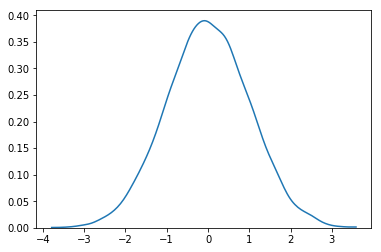

In [44]:
# evaluate log-probability from a given distribution (without using a model)
# http://docs.pymc.io/prob_dists.html#using-pymc-distributions-without-a-model
from pymc3 import plots, Normal
y = Normal.dist(mu=0, sd=1)
plots.kdeplot(y.random(size=10000))

### Using scipy.stats to plot distributions and histograms

PyMC3 offers support for these distributions but you will find it's heavily geared toward inference.  For example there is no density function (continuous) and no probability mass function (discrete), just the log-probability.  Below is an example for the normal distribution - observe that the KDE (=kernel density estimate) plot is not especially accurate.

Therefore to investige the distributions, you may find it easier to use [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) as shown below the examples using pymc3.

However, if you are running short on time, it's fine to look at wikipedia to get acquainted.

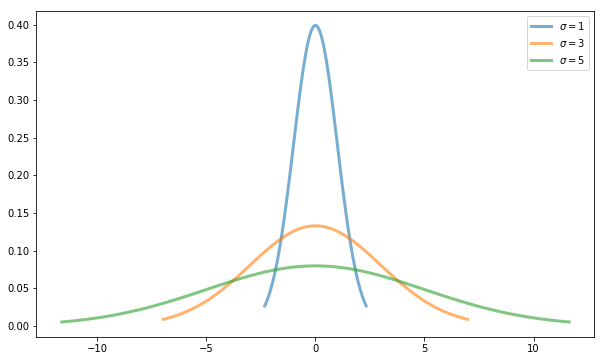

In [45]:
# taken from here: https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html
# NOTE: scipy stats uses weird names for parameters in the distributions, for example below for the normal distribution,
# we have that 'loc' is mean value and 'scale' is standard deviation (sigma).  One needs to look into the documentation
# in scipy.stats
# 
from scipy.stats import norm
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
#fit, ax = plt.subplots(1, 1)
legend = []
for sigma in [1, 3, 5]:
    x = np.linspace(norm.ppf(0.01,scale=sigma), norm.ppf(0.99,scale=sigma), 100)
    ax.plot(x, norm.pdf(x,scale=sigma), lw=3, alpha=0.6, label='norm pdf')
    legend.append('$\sigma = %g$' % sigma)
plt.legend(legend)
plt.show()

### Discrete example: binomial

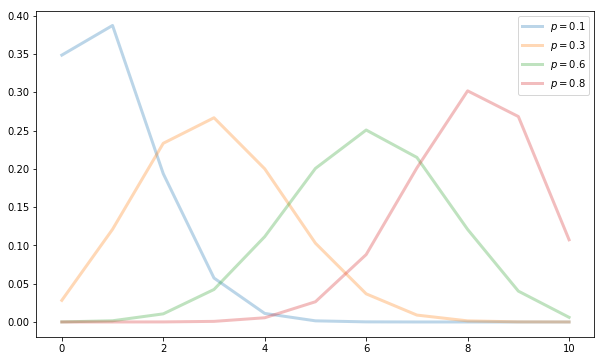

In [46]:
from scipy.stats import binom
import matplotlib.pyplot as plt

n = 10 # our choice of number of tries for the binomial distribution
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
x = range(11) # we know the universe of possible values is 0..10

legend = []
for p in [0.1, 0.3, 0.6, 0.8]:
    ax.plot(x, binom.pmf(x, n=n, p=p), lw=3, alpha=0.3, label='norm pdf')
    r = binom.rvs(n=n, p=p, size=1000)
    legend.append('$p=%g$' % p)
plt.legend(legend)
plt.show()

## PW exercise
Edit the above plots with more distributions from the selected set above to get a feel for them.  As stated above, Wikipedia is a fine plan B if you find it difficult to use the (non-intuitive) scipy package.

## References

1. Salvatier, J., Wiecki, T. V., & Fonnesbeck, C. (2016). Probabilistic programming in Python using PyMC3. PeerJ Computer Science, 2(2), e55. http://doi.org/10.7717/peerj-cs.55
2. Getting started with PyMC3 (Apache License). http://docs.pymc.io/notebooks/getting_started.html